# Code Progress for Identifying Presence or Absence of Seismic Facies in Seismic Images Using Deep Learning



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  2 22:00:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy.signal.windows import triang
from scipy.signal import convolve2d as conv2

from tqdm.notebook import tqdm #progress bar

import cv2

import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


import cv2
import imutils


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#drive = GoogleDrive()

In [3]:
data_train_parihaka = np.load('/content/drive/MyDrive/Dataset /data_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']


label_train_parihaka = np.load('/content/drive/MyDrive/Dataset /labels_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['labels']

### Data Preprocessing 
#### Loading in Dataset 1 (Parihaka)

In [4]:
print('Shape X:', data_train_parihaka.shape)
print('Shape Y:', label_train_parihaka.shape)

Shape X: (1006, 782, 590)
Shape Y: (1006, 782, 590)


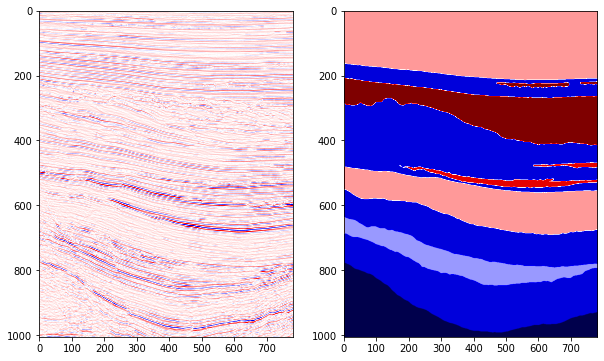

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_parihaka[:,:,200], cmap='seismic')
ax[1].imshow(label_train_parihaka[:,:,200], cmap='seismic')

#### Loading Dataset 2 (Netherlands F3 Block) 
##### We will use this one for transfer learning once we have trustworthy weights. 

In [6]:
data_train_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/train_seismic.npy')


label_train_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/train_labels.npy')

In [7]:
print('Shape X:', data_train_netherlands.shape)
print('Shape Y:', label_train_netherlands.shape)

Shape X: (401, 701, 255)
Shape Y: (401, 701, 255)


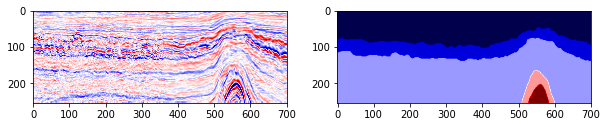

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_netherlands[400,:,:].T, cmap='seismic')
ax[1].imshow(label_train_netherlands[400,:,:].T, cmap='seismic')

In [9]:
data_test1_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/test1_seismic.npy')


label_test1_netherlands= np.load('/content/drive/MyDrive/Dataset /Dataset_2/test1_labels.npy')

In [10]:
print('Shape X:', data_test1_netherlands.shape)
print('Shape Y:', label_test1_netherlands.shape)

Shape X: (200, 701, 255)
Shape Y: (200, 701, 255)


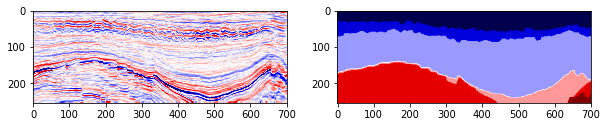

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_test1_netherlands[20,:,:].T, cmap='seismic')
ax[1].imshow(label_test1_netherlands[20,:,:].T, cmap='seismic')

## Implement Data Preprocessing 

### Gain + RMS

In [12]:
def gain(data,dt,parameters):
    nt,nx = data.shape
    dout = np.zeros(data.shape)
    L = parameters/dt+1
    L = np.floor(L/2)
    h = triang(2*L+1)
    shaped_h  = h.reshape(len(h),1)
    for k in range(nx):
        aux = data[:,k]
        e = aux**2
        shaped_e = e.reshape(len(e),1)
        rms = np.sqrt(conv2(shaped_e,shaped_h,"same"))
        epsi = 1e-10*max(rms)
        op = rms/(rms**2+epsi)
        op = op.reshape(len(op),)
        dout[:,k] = data[:,k]*op
    for k in range(nx):
        aux = dout[:,k]
        amax = np.sqrt(sum(aux**2)/nt)
        dout[:,k] = dout[:,k]/amax
    return dout

In [13]:
test_image=data_train_parihaka[:,200,:]
test_gain =gain(test_image,3e-3,0.8)

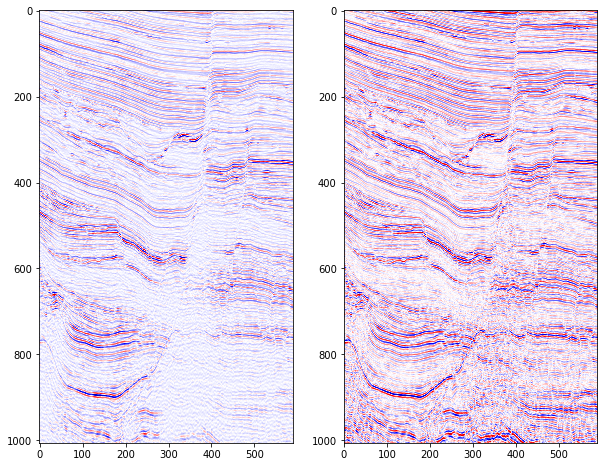

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_parihaka[:,200,:], cmap='seismic')
ax[1].imshow(test_gain, cmap='seismic')

In [15]:
# load in an RMS processed dataset
data_train_parihaka_pp = np.load('/content/drive/MyDrive/Dataset /data_train_processed.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']

2-D Image Making

In [16]:
training_img_data = []
training_label_data = []

for i in tqdm(range(0, 580)): #reshaping the images into appropriate sizes 
  img = data_train_parihaka_pp[:, :, i] 
  label = label_train_parihaka[:, :, i]

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  training_img_data.append(img) 
  training_label_data.append(label)
  

  0%|          | 0/580 [00:00<?, ?it/s]

In [17]:
print('Before Data Reshape', np.array(data_train_parihaka_pp).shape)
print('After Data Reshape', np.array(training_img_data).shape)

print('Before Target Reshape', np.array(label_train_parihaka).shape)
print('After Target Reshape', np.array(training_label_data).shape)

Before Data Reshape (1006, 782, 590)
After Data Reshape (580, 128, 128, 3)
Before Target Reshape (1006, 782, 590)
After Target Reshape (580, 128, 128)


In [18]:
training_img_data = np.asarray(training_img_data)

training_label_data = np.asarray(training_label_data)

print(training_label_data.shape)

(580, 128, 128)


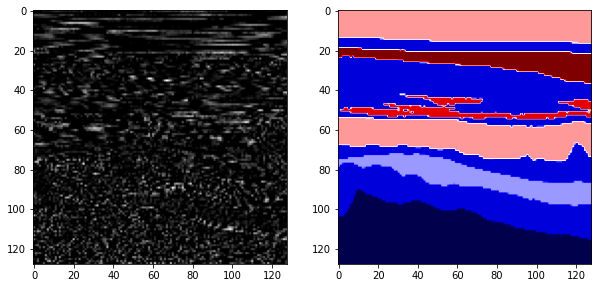

In [19]:

fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(training_img_data[0,:,:,:], cmap='seismic')
ax[1].imshow(training_label_data[0,:,:], cmap='seismic')

In [20]:
# Augmentation
datagen = ImageDataGenerator(horizontal_flip = True, shear_range = 0.2, width__shift_range=0.2, height_shift_range=0.2, rotation_range=10, zoom_range = 0.2)
datagen_test = ImageDataGenerator(horizontal_flip = True)

datagen.fit(training_img_data)

## Processing F3 Data

In [21]:
training_img_data_f3 = []
training_label_data_f3 = []

for i in tqdm(range(0, 401)): #reshaping the images into appropriate sizes 
  img = data_train_netherlands[i, :, :].T
  label = label_train_netherlands[i, :, :].T

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  training_img_data_f3.append(img) 
  training_label_data_f3.append(label)

  0%|          | 0/401 [00:00<?, ?it/s]

In [22]:
test1_img_data_f3 = []
test1_label_data_f3 = []

for i in tqdm(range(0, 200)): #reshaping the images into appropriate sizes 
  img = data_test1_netherlands[i, :, :].T 
  label = label_test1_netherlands[i, :, :].T

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  test1_img_data_f3.append(img) 
  test1_label_data_f3.append(label)

  0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
training_img_data_f3 = np.asarray(training_img_data_f3)

training_label_data_f3 = np.asarray(training_label_data_f3)

test1_img_data_f3 = np.asarray(test1_img_data_f3)

test1_label_data_f3 = np.asarray(test1_label_data_f3)


print('Converted F3 Dims:', training_img_data_f3.shape)
print('Converted F3 Dims (Test):', test1_img_data_f3.shape)

Converted F3 Dims: (401, 128, 128, 3)
Converted F3 Dims (Test): (200, 128, 128, 3)


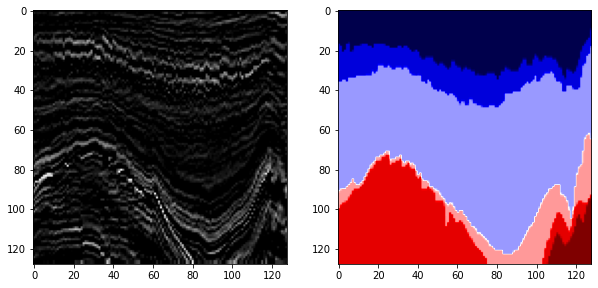

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(test1_img_data_f3[20,:,:,:], cmap='seismic')
ax[1].imshow(test1_label_data_f3[100,:,:], cmap='seismic')

In [140]:
# Augmentation
datagen_f3 = ImageDataGenerator(horizontal_flip = True, shear_range = 0.2, width_shift_range=0.2, height_shift_range=0.2, rotation_range=10, zoom_range = 0.2)

datagen_f3.fit(test1_img_data_f3)

Developing the Model Using Keras API

Attempt #1: U-Net without Augmentation

In [26]:
ACTIVATION = 'relu'
ACTIVATION_OUT = 'softmax'
initializer = 'he_normal'
input_size = np.array(training_img_data).shape[1:]
N_classes = 7


In [27]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer= tf.keras.initializers.HeNormal(),
    )(block_input)
    x = BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

#### Create the Model

In [28]:
pari_model_deeplab = DeeplabV3Plus(image_size=128, num_classes=7)


print(pari_model_deeplab.summary())

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

#### Compile the Model

Add in our optimizers. We will start with ADAM and binary cross-entropy.

In [42]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=7))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [43]:
model_path="{}.h5".format('fixed_model_deeplab_1') #hdf5
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = False)

In [44]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=30, decay_rate=0.96, staircase=True)

pari_model_deeplab.compile(optimizer=Adam(learning_rate=lr_schedule), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy' , dice_coef])

Visualize a Sample Prediction

In [45]:
print(training_img_data.shape)
print(training_label_data.shape)

(580, 128, 128, 3)
(580, 128, 128)


In [46]:

x_train, x_valid, y_train, y_valid = train_test_split(training_img_data, training_label_data,test_size=0.2, shuffle= True)

In [47]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

#tf.cast(training_label_data, tf.float32)
#model_history = pari_model_unet.fit(training_img_data, training_label_data, validation_split=0.2, epochs=50, callbacks=[tensorboard_callback])
model_history = pari_model_deeplab.fit(datagen.flow(x_train, y_train), validation_data=(x_valid, y_valid), epochs=100, callbacks=[tensorboard_callback, checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 1.1421 - accuracy: 0.5953 - dice_coef: -24.2091
Epoch 00001: val_loss improved from inf to 367234400649216.00000, saving model to fixed_model_deeplab_1.h5
15/15 [==============================] - 20s 808ms/step - loss: 1.1421 - accuracy: 0.5953 - dice_coef: -24.2091 - val_loss: 367234400649216.0000 - val_accuracy: 0.5847 - val_dice_coef: -1.9174
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.6955 - dice_coef: -5.9708
Epoch 00002: val_loss improved from 367234400649216.00000 to 21666803712.00000, saving model to fixed_model_deeplab_1.h5
15/15 [==============================] - 9s 611ms/step - loss: 0.7524 - accuracy: 0.6955 - dice_coef: -5.9708 - val_loss: 21666803712.0000 - val_accuracy: 0.4036 - val_dice_coef: -1.5883
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7266 - dice_coef: -3.6711
Epoch 00003: val_loss improved from 2166680

In [48]:
def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number - ' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val])   

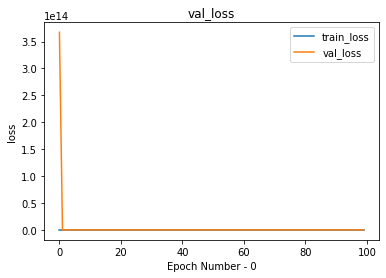

In [49]:
PlotHistory(model_history, 'loss')

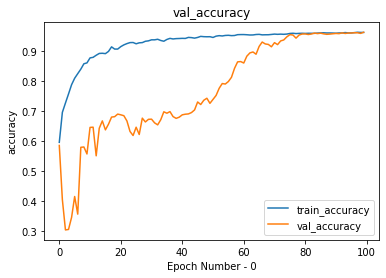

In [50]:
PlotHistory(model_history, 'accuracy')

In [51]:
pred_test = pari_model_deeplab.predict(training_img_data)
print(pred_test.shape)
pred_mask = tf.argmax(pred_test, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask = tf.expand_dims(pred_mask, axis=-1)
print(pred_mask.shape)

(580, 128, 128, 7)
(580, 128, 128, 1)


[[[[ -8.775271    -3.0213423   -4.0579185  ...  25.742678
     -9.910467    -8.514762  ]
   [ -8.775271    -3.0213423   -4.0579185  ...  25.742678
     -9.910467    -8.514762  ]
   [ -9.162671    -3.0608332   -4.3748255  ...  26.87824
    -10.479695    -8.8615885 ]
   ...
   [ -9.165847    -2.9469867   -5.213082   ...  23.523975
     -8.662139    -4.219195  ]
   [ -8.899226    -2.9674141   -4.927746   ...  22.727444
     -8.467315    -4.088877  ]
   [ -8.899226    -2.9674141   -4.927746   ...  22.727444
     -8.467315    -4.088877  ]]

  [[ -8.775271    -3.0213423   -4.0579185  ...  25.742678
     -9.910467    -8.514762  ]
   [ -8.775271    -3.0213423   -4.0579185  ...  25.742678
     -9.910467    -8.514762  ]
   [ -9.162671    -3.0608332   -4.3748255  ...  26.87824
    -10.479695    -8.8615885 ]
   ...
   [ -9.165847    -2.9469867   -5.213082   ...  23.523975
     -8.662139    -4.219195  ]
   [ -8.899226    -2.9674141   -4.927746   ...  22.727444
     -8.467315    -4.088877  ]
   [ -8

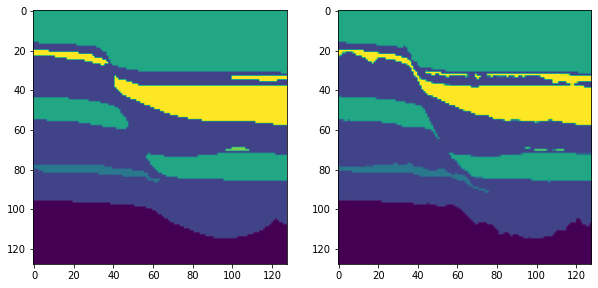

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask[400, :, :, 0])
ax[1].imshow(training_label_data[400, :, :])

print(pred_test)

Importing the Test Data

In [62]:
data_test_parihaka_1 = np.load('/content/drive/MyDrive/Dataset /data_test_1.npz')


data_test_parihaka_2 = np.load('/content/drive/MyDrive/Dataset /data_test_2.npz')

data_test_parihaka_1 = data_test_parihaka_1['data']
data_test_parihaka_2 = data_test_parihaka_2['data']

(1006, 782, 251)


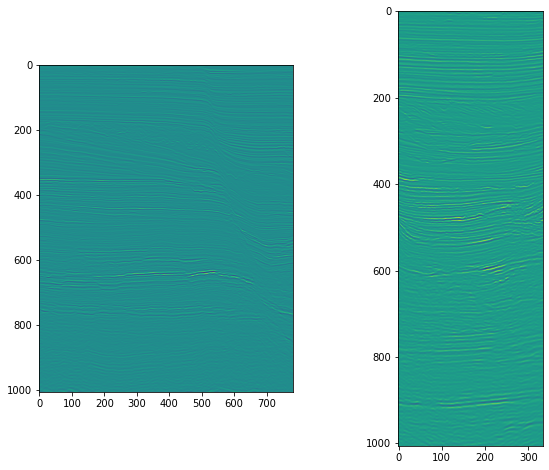

In [63]:
# Plot our test data examples
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_test_parihaka_1[:,:,1])
ax[1].imshow(data_test_parihaka_2[:,:,1])

print(data_test_parihaka_1.shape)

In [64]:
testing_img_data_1 = []
testing_img_data_2 = []

def preprocess_input(data_in, data_out, axis):
  for i in range(0, axis):
    img = data_in[:, :, i]
    img = np.expand_dims(img, axis=2).astype('float32')
    

    img = cv2.resize(img, (128, 128))

    img = img/np.amax(img)
    img = np.clip(img, 0, 255)
    img = (img*255).astype(int)
    img = cv2.merge([img,img,img])

    data_out.append(img)

  return data_out

testing_img_data_1 = preprocess_input(data_test_parihaka_1, testing_img_data_1, 251)
testing_img_data_2 = preprocess_input(data_test_parihaka_2, testing_img_data_2, 251)

In [65]:
testing_img_data_1 = np.asarray(testing_img_data_1)
testing_img_data_2 = np.asarray(testing_img_data_2)

In [66]:
testing_img_data_1.shape

(251, 128, 128, 3)

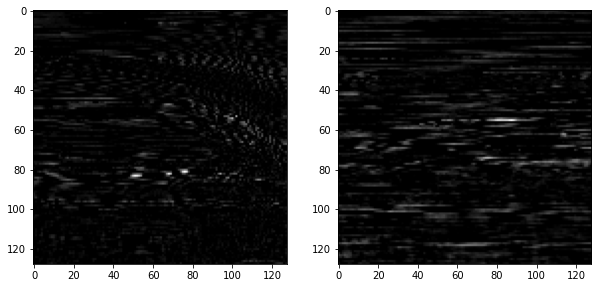

In [67]:
# Plot our test data examples
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(testing_img_data_1[100,:,:,:])
ax[1].imshow(testing_img_data_2[100,:,:,:])

In [75]:
pred_test_data_pari = pari_model_deeplab.predict(testing_img_data_2)

print(pred_test_data_pari.shape)
pred_mask_test_pari = tf.argmax(pred_test_data_pari, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_test_pari = tf.expand_dims(pred_mask_test_pari, axis=-1)
print(pred_mask_test_pari.shape)


(251, 128, 128, 7)
(251, 128, 128, 1)


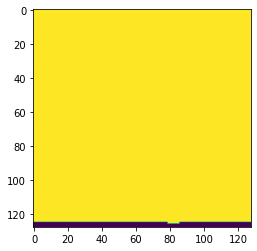

In [80]:
plt.imshow(pred_mask_test_pari[0, :, :, 0])

Text(0.5, 0.98, 'Prediction with Test (Parihaka)')

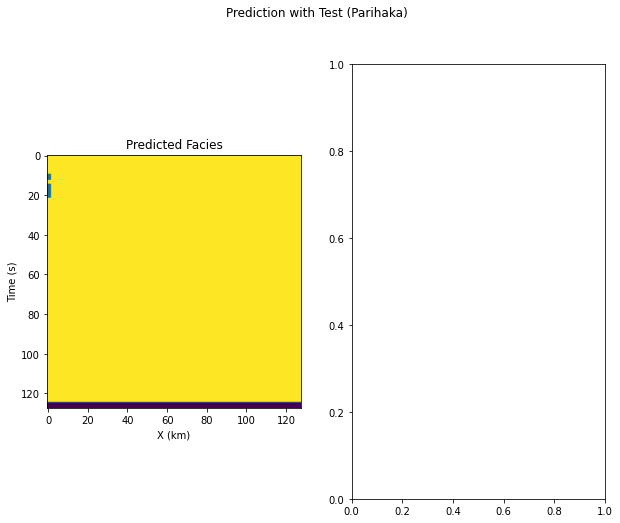

In [74]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_test_pari[50, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
fig.suptitle('Prediction with Test (Parihaka)')

# Transfer Learning with U-Net 

In [84]:
dependencies = {
    'dice_coef': dice_coef
}

#base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')
base_model = tf.keras.models.load_model('/content/fixed_model_deeplab_1.h5', custom_objects=dependencies)

In [85]:
# for layer in base_model.layers:
#   layer.trainable = False

for layer in base_model.layers[:69]:
   layer.trainable = False
for layer in base_model.layers[69:]:
   layer.trainable = True

In [ ]:
N_CLASSES_F3 = 7
transfer_out = base_model.output
transfer_out = tf.keras.layers.Conv2D(N_CLASSES_F3, 1, activation = 'softmax', name='transfer_notune')(transfer_out)

In [ ]:
transfer_model_deeplab = tf.keras.Model(inputs=base_model.input, outputs=transfer_out)

In [ ]:
#for layer in base_model.layers:
  #layer.trainable = False

In [ ]:
model_path_transfer = "{}.h5".format('fixed_model_deeplab_1_transfer') #hdf5
checkpoint = ModelCheckpoint(model_path_transfer, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
transfer_model_deeplab.compile(optimizer=Adam(learning_rate=0.001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', dice_coef])

In [ ]:
x_split, x_test_f3, y_split, y_test_f3 = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.98, shuffle= False)
x_train_f3, x_val_f3, y_train_f3, y_val_f3 = train_test_split(x_split, y_split, test_size=0.2, shuffle= False)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

# transfer_model_history = transfer_model_unet.fit(x_train_f3, y_train_f3, validation_data=(x_val_f3, y_val_f3), epochs=20 callbacks=[tensorboard_callback, checkpoint]) 
transfer_model_history = transfer_model_deeplab.fit(datagen_f3.flow(x_train_f3, y_train_f3), validation_data=(x_val_f3, y_val_f3), epochs=400, callbacks=[tensorboard_callback])

Epoch 1/400
1/1 [==============================] - 9s 9s/step - loss: 1.7920 - accuracy: 0.1536 - val_loss: 1.7934 - val_accuracy: 0.1970
Epoch 2/400
1/1 [==============================] - 6s 6s/step - loss: 1.7857 - accuracy: 0.1578 - val_loss: 1.7904 - val_accuracy: 0.2017
Epoch 3/400
1/1 [==============================] - 6s 6s/step - loss: 1.7817 - accuracy: 0.1700 - val_loss: 1.7875 - val_accuracy: 0.2068
Epoch 4/400
1/1 [==============================] - 6s 6s/step - loss: 1.7822 - accuracy: 0.1759 - val_loss: 1.7845 - val_accuracy: 0.2661
Epoch 5/400
1/1 [==============================] - 5s 5s/step - loss: 1.7802 - accuracy: 0.2586 - val_loss: 1.7815 - val_accuracy: 0.3409
Epoch 6/400
1/1 [==============================] - 6s 6s/step - loss: 1.7745 - accuracy: 0.2968 - val_loss: 1.7786 - val_accuracy: 0.3603
Epoch 7/400
1/1 [==============================] - 6s 6s/step - loss: 1.7724 - accuracy: 0.3125 - val_loss: 1.7756 - val_accuracy: 0.3705
Epoch 8/400
1/1 [=================

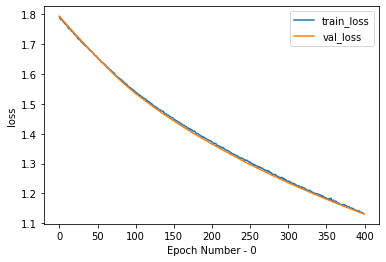

In [ ]:
PlotHistory(transfer_model_history, 'loss')

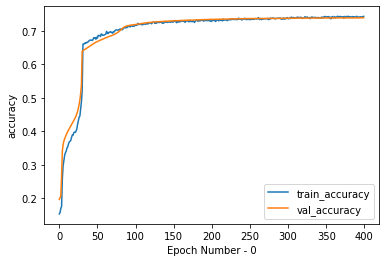

In [ ]:
PlotHistory(transfer_model_history, 'loss')

In [ ]:
pred_test_f3 = transfer_model_deeplab.predict(x_train_f3)
print(pred_test_f3.shape)
pred_mask_f3 = tf.argmax(pred_test_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3 = tf.expand_dims(pred_mask_f3, axis=-1)
print(pred_mask_f3.shape)

(32, 128, 128, 7)
(32, 128, 128, 1)


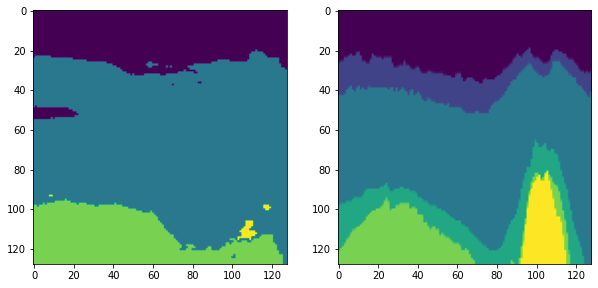

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_f3[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
ax[1].imshow(y_train_f3[4, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Predicted Facies')
fig.suptitle('Transfer Learning Prediction with Training (Netherlands F3)')

# Now knowing the information from the Parihaka is overbearing in the transfer learning, we need to fine tune with transfer learning

In [220]:
# base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')

dependencies = {
    'dice_coef': dice_coef
}

#base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')
base_model = tf.keras.models.load_model('/content/fixed_model_deeplab_1.h5', custom_objects=dependencies)

In [221]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [222]:
for layer in base_model.layers[:70]:
   layer.trainable = False
for layer in base_model.layers[70:]:
   layer.trainable = True

# base_model.trainable = False

for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [223]:
N_CLASSES_F3 = 7
transfer_out = base_model.output
transfer_out = Dense(1024, activation='relu')(base_model.output)
transfer_out = Dropout(0.2, name='drop_transfer1')(transfer_out)
# transfer_out = Dense(512, activation='relu')(transfer_out)
# transfer_out = Dropout(0.1, name='drop_transfer2')(transfer_out)
# transfer_out = Dense(256, activation='relu')(transfer_out)
# transfer_out = Dropout(0.1, name='drop_transfer3')(transfer_out)
# transfer_out = Dense(128, activation='relu')(transfer_out)
# transfer_out = Dropout(0.05, name='drop_transfer3')(transfer_out)
transfer_out = tf.keras.layers.Conv2D(N_CLASSES_F3, 1, activation = 'softmax', name='transfer')(transfer_out)

In [224]:
transfer_model_deeplab = tf.keras.Model(inputs=base_model.input, outputs=transfer_out)

In [225]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=7))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number - ' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val])   

In [226]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=30, decay_rate=0.96, staircase=True)

#lr_schedule = 0.0001

transfer_model_deeplab.compile(optimizer=Adam(learning_rate=lr_schedule), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', dice_coef])

#x_split, x_test_f3, y_split, y_test_f3 = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.985, shuffle= False) #take out of the bunch of the data
x_train_f3, x_test_f3_throw, y_train_f3, y_test_f3_throw = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.98, shuffle= False) #take out of the bunch of the data

#x_train_f3, x_val_f3_throw, y_train_f3, y_val_f3_throw = train_test_split(x_split, y_split, test_size=0, shuffle= False) # split train and validation 

x_val_f3, x_test_f3, y_val_f3, y_test_f3 = train_test_split(test1_img_data_f3, test1_label_data_f3,test_size=0.95, shuffle= False) #take out of the bunch of the data

Text(0.5, 1.0, 'True Facies (Labels)')

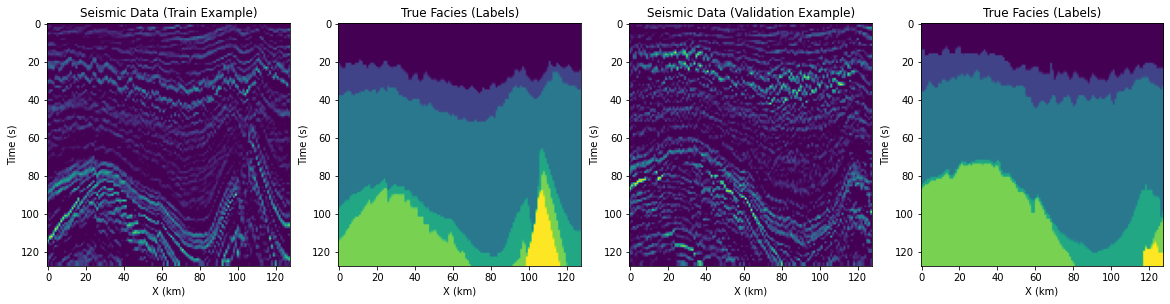

In [227]:
fig, ax = plt.subplots(1,4, figsize=(20,20))

ax[0].imshow(x_train_f3[0, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Seismic Data (Train Example)')
ax[1].imshow(y_train_f3[0, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('True Facies (Labels)')
ax[2].imshow(x_val_f3[0, :, :, 0])
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Time (s)')
ax[2].set_title('Seismic Data (Validation Example)')
ax[3].imshow(y_val_f3[0, :, :])
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Time (s)')
ax[3].set_title('True Facies (Labels)')

In [228]:
x_val_f3.shape
x_train_f3.shape

(8, 128, 128, 3)

In [229]:
model_path_transfer = "{}.h5".format('fixed_model_deeplab_1_transfer_tuned_1') #hdf5
checkpoint = ModelCheckpoint(model_path_transfer, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)
early_stop = EarlyStopping(monitor="val_dice_coef",mode="max",patience=300)

In [230]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

#transfer_model_history = transfer_model_deeplab.fit(x_train_f3, y_train_f3, validation_data=(x_val_f3, y_val_f3), epochs=100, callbacks=[tensorboard_callback, early_stop])
transfer_model_history = transfer_model_deeplab.fit(datagen_f3.flow(x_train_f3, y_train_f3), validation_data=(x_val_f3, y_val_f3), epochs=100, callbacks=[tensorboard_callback, early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: 3.1070 - accuracy: 0.1121 - dice_coef: 0.1417 - val_loss: 3.0617 - val_accuracy: 0.6781 - val_dice_coef: 0.6429
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 2.3201 - accuracy: 0.6503 - dice_coef: 0.6101 - val_loss: 1.9028 - val_accuracy: 0.7508 - val_dice_coef: 0.7528
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 1.4875 - accuracy: 0.6861 - dice_coef: 0.6497 - val_loss: 1.8930 - val_accuracy: 0.4985 - val_dice_coef: 0.5230
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.6859 - accuracy: 0.5043 - dice_coef: 0.4679 - val_loss: 2.1367 - val_accuracy: 0.7393 - val_dice_coef: 0.7373
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 0.9073 - accuracy: 0.7454 - dice_coef: 0.6931 - val_loss: 37.9197 - val_accuracy: 0.5921 - val_dice_coef: 0.5987
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 0.8659 - accuracy

In [ ]:
PlotHistory(transfer_model_history, 'loss')

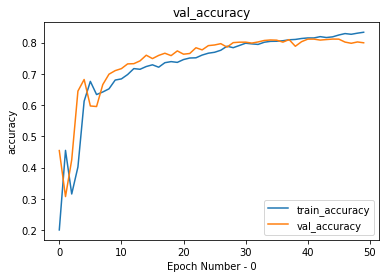

In [130]:
PlotHistory(transfer_model_history, 'accuracy')

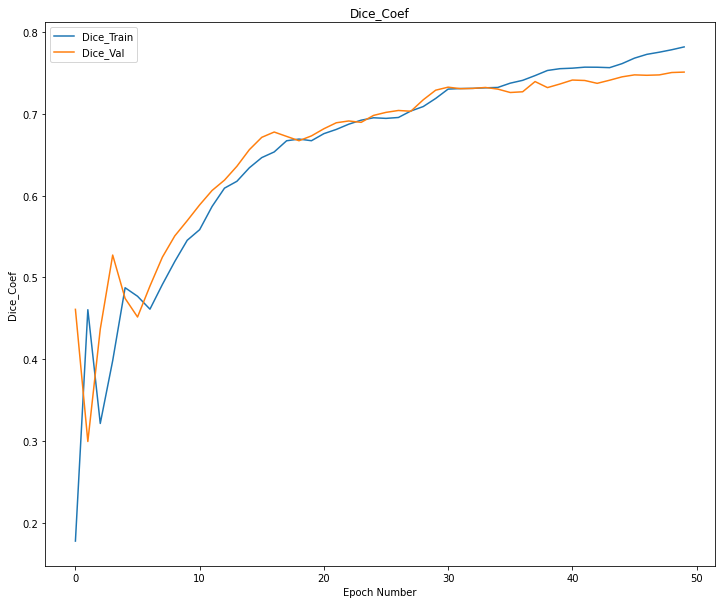

In [131]:
plt.figure(figsize=(12,10))
plt.xlabel('Epoch Number')
plt.ylabel('Dice_Coef')
plt.plot(transfer_model_history.history['dice_coef'])
plt.plot(transfer_model_history.history['val_dice_coef'])
plt.title('Dice_Coef')
plt.legend(["Dice_Train", "Dice_Val"])   
plt.show()

In [132]:
pred_train_f3 = transfer_model_deeplab.predict(x_train_f3)
print(pred_train_f3.shape)
pred_mask_f3 = tf.argmax(pred_train_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3 = tf.expand_dims(pred_mask_f3, axis=-1)
print(pred_mask_f3.shape)

(8, 128, 128, 7)
(8, 128, 128, 1)


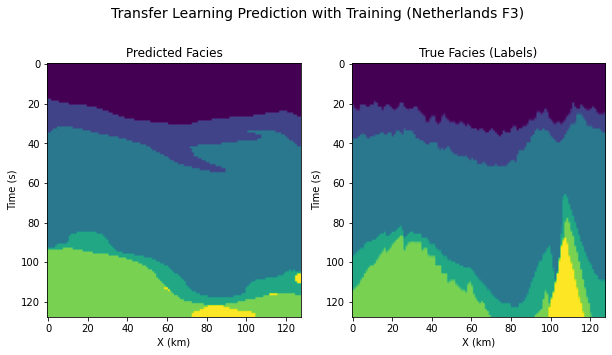

In [133]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_f3[0, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
ax[1].imshow(y_train_f3[0, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('True Facies (Labels)')
fig.suptitle('Transfer Learning Prediction with Training (Netherlands F3)', fontsize=14, y=0.82)
plt.show()

In [134]:
pred_test_f3 = transfer_model_deeplab.predict(x_test_f3)
print(pred_test_f3.shape)
pred_mask_f3_test = tf.argmax(pred_test_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3_test = tf.expand_dims(pred_mask_f3_test, axis=-1)
print(pred_mask_f3_test.shape)

(190, 128, 128, 7)
(190, 128, 128, 1)


In [135]:
transfer_model_deeplab.evaluate(x=x_test_f3, y=y_test_f3, callbacks=[tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6/6 [==============================] - 1s 191ms/step - loss: 0.5121 - accuracy: 0.8029 - dice_coef: 0.7601


[0.512094259262085, 0.8028567433357239, 0.7600724697113037]

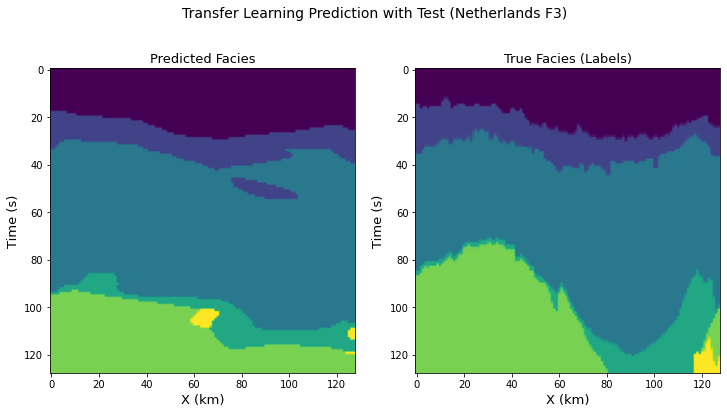

In [136]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(pred_mask_f3_test[1, :, :, 0])
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(y_test_f3[1, :, :])
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()

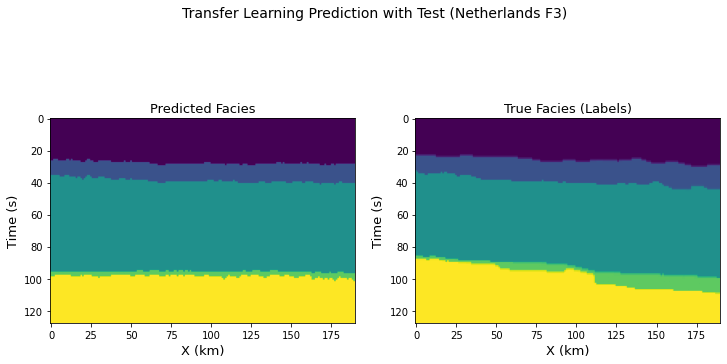

In [138]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(tf.keras.backend.transpose(pred_mask_f3_test[:, :, 50, 0]))
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(tf.keras.backend.transpose(y_test_f3[:, :, 50]))
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()